# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Eduardo Rodríguez Cao</mark>

# <font color='blue'>**Ejercicio  3: Transfer Learning y fine-tuning con ResNet50 en el SPR X-Ray Age Prediction Challenge (3.5 points)**
<font color='blue'>En este ejercicio trabajaremos con el _SPR X-Ray Age Prediction Challenge_ de Kaggle (https://www.kaggle.com/competitions/spr-x-ray-age/data). Este dataset consta de $10 702$ radiografías de tórax, y el objetivo es predecir la edad de la persona a partir de la imagen de la radiografía. En esta ocasión, se emplearán $6 702$ imágenes para entrenamiento y $4 000$ para test. Las edades oscilan entre los 18 y los 89 años. Para facilitar el trabajo al alumnado se proporciona una versión procesada de los datos (con resolución $224\times224$, en lugar de $1024\times1024$, y empleando solo ejemplos para los cuales se tiene salida deseada (dado que, al tratarse de una challenge de kaggle, el conjunto de test está disponible pero sin etiquetar)). Estos datos se pueden acceder desde: https://drive.google.com/drive/folders/1hCWfTLs1w0h5kObl6NEIhEtH5VDmmCnj?usp=sharing (se debe emplear una cuenta de la UGR para acceder a dicha URL, y la información allí contenida (directorio `spr-x-ray-age`) se debe incluir en la carpeta `Colab Notebooks`).

<font color='blue'>Se debe emplear un $20\%$ de los datos de entrenamiento para validación, y el rendimiento debe ser evaluado, como mínimo, por medio de $MSE$, $MAE$ y $R^2$ _(coefficient of determination) score_. Se deben justificar las decisiones tomadas, como la elección de la función de pérdida. Del mismo modo, es necesario hacer un `summary()` de las arquitecturas empleadas en cada apartado, indicando qué parámetros/capas/bloques son entrenables y cuáles no lo son (es decir, en cada apartado es imprescindible destacar claramente qué arquitectura exacta se está utilizando, así como qué pesos se están entrenando y cuáles se están congelando).

<font color='blue'>Usaremos un modelo ResNet50 pre-entrenado en ImageNet, y tendremos que realizar los siguientes experimentos en relación a la estrategia de entrenamiento:

<font color='blue'>1. Partimos de ResNet50, adaptamos la cabecera (sustituyendo la cabecera anterior por *una única fully-connected* con el número de neuronas de salida adecuado), y reentrenamos (_from scratch_) la red entera para este nuevo problema. Es decir, partimos de pesos aleatorios para resolver este problema de regresión.

<font color='blue'>2. Partimos de ResNet50, adaptamos la cabecera (empleando la misma del apartado anterior), y entrenamos solo la cabecera incorporada. Es decir, ResNet50 se usa como un mero extractor de características, y los pesos que se entrenan son los de la nueva capa incorporada (manteniendo fijos/congelados todos los demás).  

<font color='blue'>3. Partimos de ResNet50, dejamos que fastai incorpore su cabecera por defecto (véase https://wandb.ai/capecape/imagenette_timm/reports/Checking-Out-the-New-fastai-timm-Integration--VmlldzoxOTMzNzMw o https://docs.fast.ai/vision.learner.html#head-and-model), y entrenamos solo la cabecera incorporada. Es decir, de nuevo, ResNet50 se usa como extractor de características, y los pesos que se entrenan son los de las nuevas capas incorporadas

<font color='blue'>4. Partimos de ResNet50, adaptamos la cabecera (puede ser la del apartado 3.2 o la del 3.3), y hacemos un ajuste fino de toda la red partiendo de los pesos de ResNet50 (preentrenada en ImageNet).



<font color='blue'>Es importante remarcar que estamos intentando resolver un problema de regresión por medio de la reutilización de un modelo pre-entrenado en un problema de clasificación (ImageNet). ¿Tiene sentido hacerlo? ¿Por qué nos sirven pesos entrenados en clasificación para un problema de regresión? ¿No son, acaso, problemáticas muy diferentes?

Sí tiene sentido. ResNet50 se ha entrenado con ImageNet y ha aprendido representaciones genéricas de distintas imágenes, en particular puede detectar bordes, texturas y distintos tipos de patrones y estructuras jerárquicas que son útiles para muchas tareas de visión por computador. Este conocimiento de "bajo nivel" puede transferirse a otros problemas que no tienen por qué ser del mismo tipo, es decir, pueden ser de regresión. Claro está, no se puede transferir tal cual, aunque podemos aprovechar las capas inferiores, las superiores están entrenadas para tareas distintas de las nuestras y tendrán que reemplazarse por algo más apropiado.

La idea intuitiva de esto es que, por ejemplo, un estudiante adquiere ciertos conocimientos y es capaz de realizar tareas de "alto nivel", como hacer exámenes con éxito, o realizar ejercicios tipo. Si este estudiante obtiene un trabajo en el que se requieren sus conocimientos, en general no es capaz de realizarlos con éxito de inmediato. Necesita adaptarse a las nuevas tareas que se le proponen, manteniendo sus conocimientos (capas inferiores) pero alterando las formas de aplicar esos conocimientos (capas superiores). Este proceso a menudo obliga al estudiante modificar un poco sus conocimientos, ya que realizando tareas nuevas este descubre matices que no había visto antes.

De la misma forma, nosotros podemos adaptar ResNet50 a un problema de regresión, cambiando las capas superiores y entrenándolas sin o con las capas inferiores. Es interesante pensar también en que ResNet50 no se ha entrenado con imágenes de radiografías sino por ejemplo gatos y perros. Aún así es bastante útil por lo que ya hemos dicho.

## Instalación de librerías y funciones auxiliares.

In [ ]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━

In [ ]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

##  Descarga y lectura de datos, creación de conjuntos de entrenamiento y test.

In [ ]:
# defining the paths to images and labels
train_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/train'
test_folder = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/test'
csv_path = 'gdrive/MyDrive/Colab Notebooks/spr-x-ray-age/All_labels.csv'

In [ ]:
if os.path.exists(csv_path):
    print("CSV File exists!")
    # reading the labels dataframe
    df = pd.read_csv(csv_path, dtype=float, index_col=0)
    print(f'Dataframe shape: {df.shape}')
else:
    print("File does not exist.")

CSV File exists!
Dataframe shape: (10702, 1)


In [ ]:
# defining the dataset paths
train_path = Path(train_folder)
test_path = Path(test_folder)

# reading the folders looking for images
train_files = get_image_files(train_path)
test_files = sorted(get_image_files(test_path))

print(f'{len(train_files)} files were found for training and {len(test_files)} files were found for test')

6702 files were found for training and 4000 files were found for test


Age varies from 18.0 to 89.0



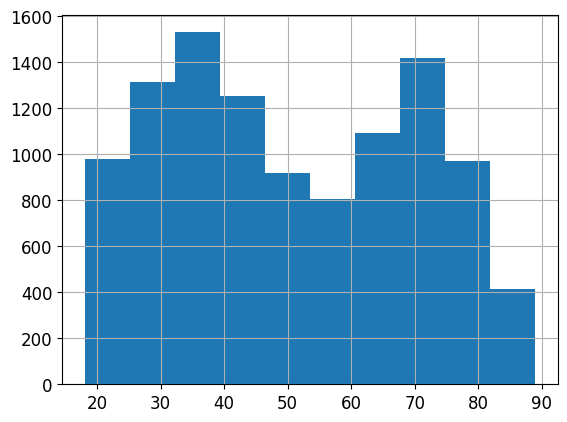

In [ ]:
print(f'Age varies from {df.age.min()} to {df.age.max()}\n')
_=df.age.hist()

In [ ]:
# function used to retun the label from an image
def label_func(file):
    # takes the file's base name w/o the extension
    basename = int(os.path.basename(str(file)).split('.')[0])

    # searches for the label
    label = int(df.age[basename])

    return label

##  DataBlock y DataLoaders.

En el `DataBlock` de este problema tenemos un bloque `RegressionBlock` por tener un problema de regresión, el mismo getter de las imágenes `get_image_files`, splitter rándom con un $20\%$ del conjunto de entrenamiento en validación, un getter de las etiquetas personalizado, definido por el profesor en la celda anterior que extrae las etiquetas del csv con las etiquetas que hemos descargado, y un `Resize` de las imágenes en `item_tfms` para estar seguros que las imágenes tienen dimension $224 \times 224$, que en principio ya sabemos por el enunciado.
El dataloader que tenemos extrae los datos del path de entrenamiento y tiene un tamaño de batch $32$, que es el tamaño por defecto que hemos estado usando en los ejercicios por que se considera un buen tamaño por defecto, no demasiado grande ni pequeño.

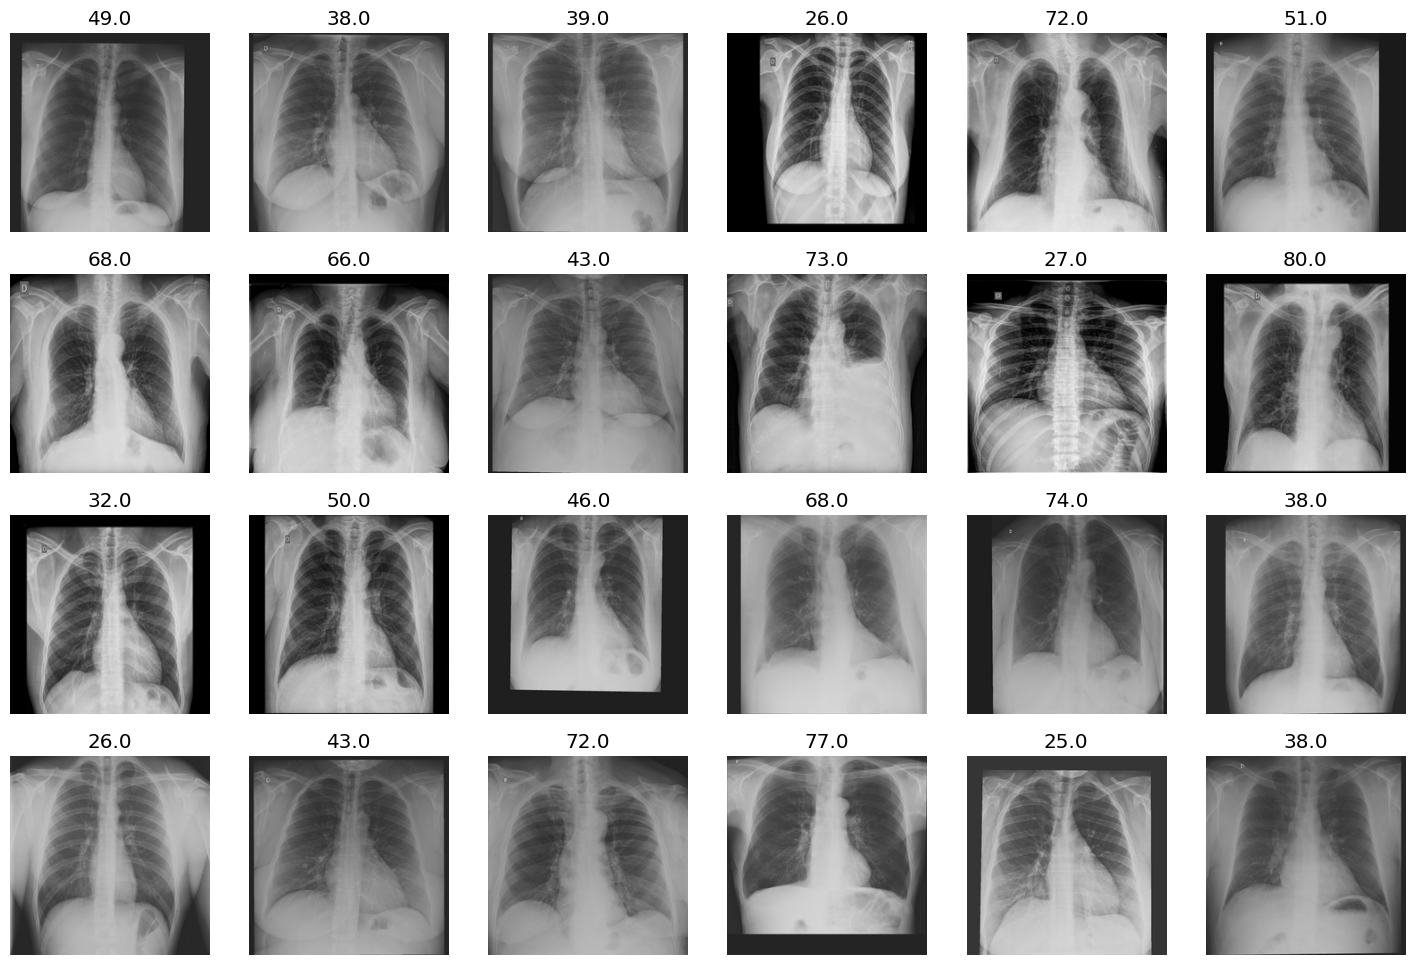

In [ ]:
# DataBlock y dataloader del problema
dtblk = DataBlock(
  blocks    = (ImageBlock, RegressionBlock),                # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.2, seed = 42),   # Entrenamiento y validación (80%/20%)
  get_y     = label_func,                                   # Etiquetas extraidas con nuestra función
  item_tfms = Resize(224),                                  # Resize de imágenes a 224x224
)
dls = dtblk.dataloaders(train_folder, bs = 32)

# Algunos ejemplos
dls.show_batch(max_n=24)

## <font color='blue'>3.1 Entrenamos todo ResNet50 _from scratch_, ajustando la cabecera para este problema.

Hablemos un poco de ResNet50. ResNet50 es una arquitectura de red neuronal profunda diseñada para clasificación y detección de objetos. Utiliza bloques residuales, que permiten que el modelo aprenda mejor al facilitar el flujo de información y gradientes a través de atajos (skip connections), mitigando problemas como el desvanecimiento del gradiente en redes muy profundas. Tiene 50 capas con combinaciones de convoluciones, normalizaciones, activaciones y un promedio adaptativo para reducir las dimensiones antes de la capa final completamente conectada. Entrenado en ImageNet, es ampliamente usado como base para transfer learning en tareas diversas debido a su capacidad para extraer características generales efectivas.

Al final de ResNet50 vemos un `AdaptiveAvgPool2d` y una capa densa. `AdaptiveAvgPool2d` con `output_size=(1, 1)` hace pooling con un tamaño de salida especificado. En este caso lo que hace es por cada canal calcula el promedio de todo, obteniendo un valor, de modo que la salida de esta capa es de tamaño el número de canales de entrada. Todo eso entra en la última capa densa, cuya salida es $1000$ neuronas, una por cada clase en ImageNet.

Veamos la arquitectura de ResNet50.

In [ ]:
models.resnet50() # Arquitectura

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Como podemos ver, a nosotros nos interesan las dos últimas capas que queremos sustituir. El resto es la arquitectura que queremos mantener, que consta de 4 capas con bloques "cuello de botella". No entraremos en los detalles de cómo funciona ResNet50.

Ahora vamos a crear nuestra cabecera básica, adaptada al problema de regresión que tenemos. En este caso, copiaremos la última capa de ResNet50, es decir usaremos un `AdaptiveAvgPool2d`, un `Flatten` y el `Linear` último, con una única salida ya que el problema es de regresión. Aunque no hace falta como se puede ver en la arquitectura de ResNet50, pongo el `Flatten` explícitamente. PyTorch hace el flattening automáticamente cuando ve que hay un tensor que ya está aplanado.

Para crear el learner usamos `vision_learner` que recibe nuestro dataloader, el modelo preentrenado ResNet50, `pretrained=False`, ya que por defecto está a True y nosotros queremos entrenar from scratch, las métricas, en nuestro caso MSE, MAE y R2score, y finalmente nuestra cabecera personalizada. Recordamos que MSE (Mean Squared Error) es el error cuadrático medio, MAE (Mean Absolute Error) es el error absoluto medio y R2score el coeficiente de determinación que mide qué tan bien el modelo explica la variabilidad de los datos. Toma valores en $[0,1]$, $0$ cuando el modelo es peor que usar la media como predicción y $1$ cuando el ajuste es perfecto. Por lo tanto al interpretar las métricas queremos que el MSE y MAE sean pequeños y el R2score lo más cercano a $1$ posible.



`vision_learner` automáticamente reconoce que tenemos un problema de regresión, viendo el `RegressionBlock` de nuestro dataloader, y por defecto escoge FlattenedLoss de MSEloss, es decir tenemos MSE como función de pérdida. Opto por MSE porque se considera una función por defecto bastante buena y estándar, se usa MAE en casos de que tengamos outliers problemáticos que pueden obstaculizar el entrenamiento (ya que MAE no penaliza tanto a los outliers como MSE, que es el error cuadrático vs el error absoluto de MAE), pero como nosotros parece que no tenemos muchos outliers ya que la calidad de los datos es bastante buena, optamos por MSE por defecto. Hacemos un summary para ver cómo ha quedado el learner.



In [ ]:
# Nuestra cabecera
custom_head = sequential(
    nn.AdaptiveAvgPool2d(output_size = (1, 1)),
    nn.Flatten(),
    nn.Linear(in_features = 2048, out_features = 1)
)
# Learner
learn = vision_learner(dls, models.resnet50, pretrained = False, metrics=[mse, mae, R2Score()], custom_head = custom_head)
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      True      
BatchNorm2d                        

Como podemos ver, todos los parámetros son entrenables, que es lo que queremos para entrenar from scratch. El optimizador por defecto es Adam como ya sabemos y la función de pérdida es MSE. Ahora procedemos a entrenar con 1cycle durante $10$ épocas, una cantidad ni muy grande ni muy pequeña, suficiente para este ejercicio.

epoch,train_loss,valid_loss,mse,mae,r2_score,time
0,461.112518,399.339417,399.339417,16.111198,-0.138435,46:33
1,317.668274,791.915649,791.915649,22.971064,-1.257589,01:15
2,242.673340,331.003601,331.003601,14.573824,0.056377,01:15
3,171.752136,219.333893,219.333893,11.841795,0.374724,01:13
4,141.313492,429.363464,429.363464,17.071682,-0.224027,01:15
5,130.660568,123.885078,123.885078,8.845158,0.646829,01:13
6,108.888123,136.467514,136.467514,9.170577,0.610959,01:15
7,90.375679,148.619629,148.619629,9.692862,0.576316,01:16
8,78.958717,85.428329,85.428329,7.258295,0.756461,01:13
9,68.153183,84.442909,84.442909,7.176108,0.759271,01:14


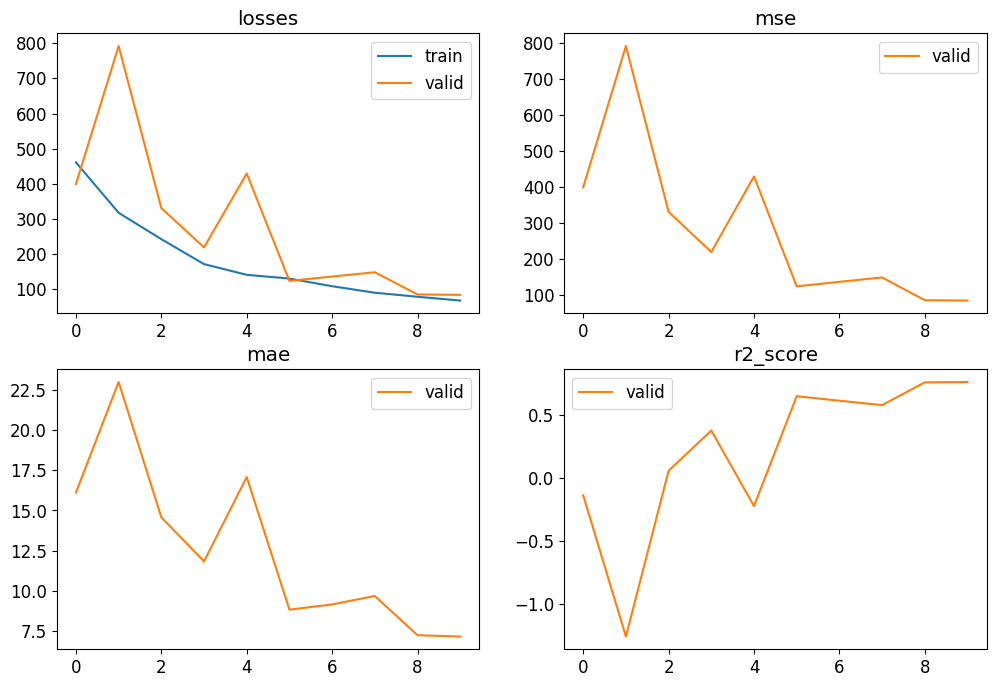

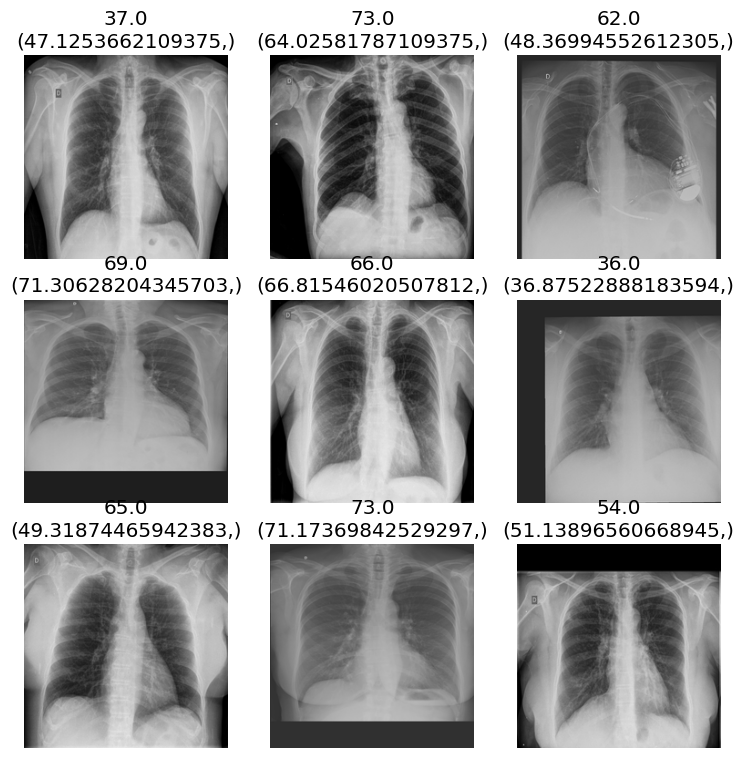

In [ ]:
# Entrenamos y vemos los resultados
learn.fit_one_cycle(n_epoch = 10)
learn.recorder.plot_metrics()
learn.show_results()

Como podemos ver en la evolución de la función de pérdida, en el entrenamiento la función decrece sin estancarse, podría seguir el entrenamiento para conseguir resultados mejores. Aunque la pérdida es muy puntiaguda, sobre todo al principio, en general decrece también y llega a acercarse a la pérdida de entrenamiento. Aunque parece ser preocupante, se podría explicar con que tenemos muy pocas épocas y el modelo no ha aprendido a generalizar al principio, por eso la pérdida salta tanto. Dicho de otra forma, se observa underfitting, ya que el modelo puede seguir entrenando todavía. Esto tiene sentido teniendo en cuenta que estamos entrenando un modelo from scratch con una arquitectura compleja. Es esperable que el modelo necesite más épocas para aprender, aunque como veremos a continuación, los resultados ya son bastante buenos. No vamos a entrenar más este modelo ya que el objetivo de este ejercicio no es obtener modelos buenos sino aprender las diferencias entre las distintas formas de hacer transfer learning.

En cuanto al resto de las métricas, se observa que aunque al principio el modelo no va muy bien, en las últimas épocas llega a unos resultados mucho mejores. El MSE y el MAE en validación baja bastante y el R2score se acerca al $1$. Ahora evaluemos el modelo en entrenamiento, validación y test.

In [ ]:
# Predicciones del modelo en el conjunto de entrenamiento
train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Calculo MSE, MAE, and R2Score
train_mse = mse(train_preds, train_targs)
train_mae = mae(train_preds, train_targs)
train_r2 = R2Score()(train_preds, train_targs)

# Resultados
print(f"\nMSE on Training Set: {train_mse.item():.4f}")
print(f"MAE on Training Set: {train_mae.item():.4f}")
print(f"R² Score on Training Set: {train_r2:.4f}")


MSE on Training Set: 57.0328
MAE on Training Set: 5.9231
R² Score on Training Set: 0.8336


In [ ]:
# Predicciones del modelo en el conjunto de validación
valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)

# Calculo MSE, MAE, and R2Score
valid_mse = mse(valid_preds, valid_targs)
valid_mae = mae(valid_preds, valid_targs)
valid_r2 = R2Score()(valid_preds, valid_targs)

# Resultados
print(f"\nMSE on Validation Set: {valid_mse.item():.4f}")
print(f"MAE on Validation Set: {valid_mae.item():.4f}")
print(f"R² Score on Validation Set: {valid_r2:.4f}")


MSE on Validation Set: 84.4429
MAE on Validation Set: 7.1761
R² Score on Validation Set: 0.7593


In [ ]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(test_files, with_labels = True)

# Predicciones del modelo entrenado en el conjunto de test
test_preds, test_targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Calculo MSE, MAE, and R2Score
test_mse = mse(test_preds, test_targs)
test_mae = mae(test_preds, test_targs)
test_r2 = R2Score()(test_preds, test_targs)

# Resultado
print(f"\nMSE on Test Set: {test_mse.item():.4f}")
print(f"MAE on Test Set: {test_mae.item():.4f}")
print(f"R² Score on Test Set: {test_r2:.4f}")


MSE on Test Set: 84.7691
MAE on Test Set: 7.2236
R² Score on Test Set: 0.7801


Aunque hay una pequeña diferencia entre entrenamiento y validación/test, en general un MAE relativamente pequeño significa que el modelo predice bastante bien. En test, por ejemplo, un error absoluto medio de unos 7 años parece bastante razonable, y eso teniendo en cuenta que podríamos seguir entrenando. Resumiendo, parece que entrenar from scratch permite adaptar la arquitectura de modelos potentes a problemas específicos bastante bien, sin usar conocimientos extraídos de otros problemas. Pero se ve que requiere bastante cómputo (más tiempo de entrenamiento) y es costoso, además de que obviamente requiere muchos datos. En nuestro caso que tenemos $6702$ imágenes para entrenamiento, se podría decir que no tenemos un dataset muy grande, podríamos tener overfitting entrenando from scratch. Veamos qué otras opciones tenemos.

## <font color='blue'>3.2. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada.



Ahora queremos congelar todas las capas del modelo menos la cabecera. Usamos ResNet50 como extractor de características: utilizamos el conocimiento adquirido por el modelo sin modificar los pesos preentrenados. Para eso volvemos a usar `vision_learner`, solo que ahora `pretrained=True`, tal y como biene por defecto, y `train_bn=False`, opción con la que evitamos que se entrenen las capas de batch normalization, ya que por defecto está a True y nosotros queremos congelar todo el modelo.

In [ ]:
# Learner
learn = vision_learner(dls, models.resnet50, train_bn = False, metrics=[mse, mae, R2Score()], custom_head = custom_head)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Observamos como todas las capas internas están congeladas y solo se pueden entrenar los parámetros de la cabecera, tal y como queríamos. Procedemos a entrenar.

epoch,train_loss,valid_loss,mse,mae,r2_score,time
0,2511.062744,2297.035400,2297.035400,43.908634,-5.548377,00:46
1,1225.197266,934.756897,934.756897,24.924644,-1.664800,00:49
2,613.471375,574.557129,574.557129,20.327976,-0.637944,00:47
3,520.358887,524.689758,524.689758,19.484879,-0.495783,00:47
4,460.038483,480.484467,480.484467,18.627871,-0.369762,00:47
5,420.295502,443.807465,443.807465,17.871040,-0.265204,00:47
6,394.425903,419.644348,419.644348,17.388687,-0.196320,00:45
7,384.352234,409.531860,409.531860,17.175253,-0.167491,00:48
8,369.313599,405.963898,405.963898,17.063965,-0.157319,00:46
9,366.223389,402.773315,402.773315,17.006886,-0.148224,00:46


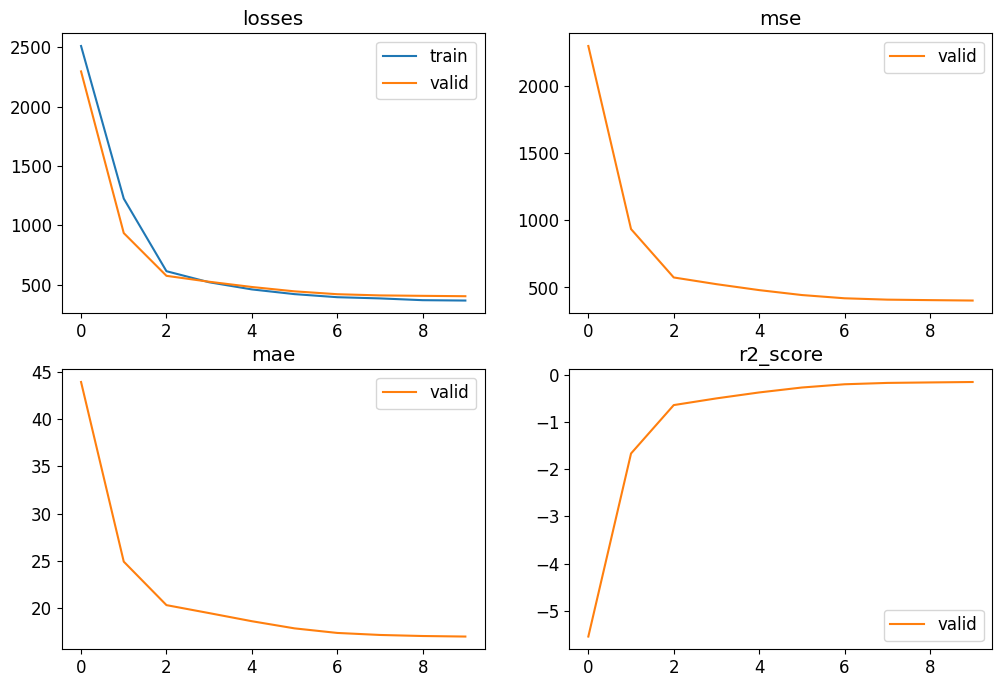

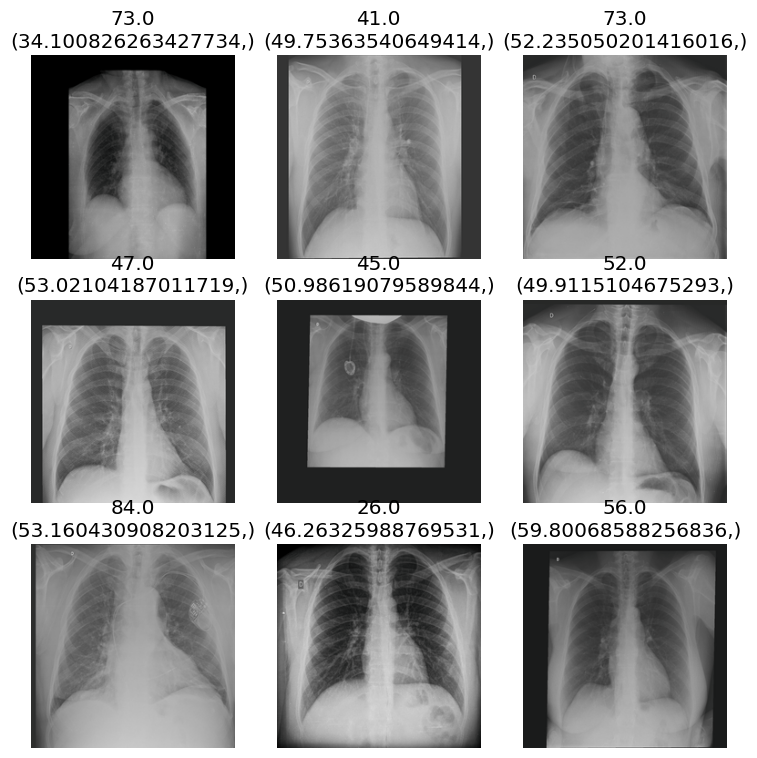

In [ ]:
# Entrenamiento y resultados
learn.fit_one_cycle(n_epoch = 10)
learn.recorder.plot_metrics()
learn.show_results()

Viendo la evolución de la pérdida queda claro que aunque disminuye mucho al principio se estanca con un valor bastante elevado tanto en entrenamiento como en validación. Este resultado es esperable, ya que estamos intentado usar ResNet50 únicamente como extractor de características, sin adaptarlo a nuestro problema. Si el problema fuera del mismo dominio, los resultados podrían ser mejores, pero tenemos un dominio muy específico de imágenes de radiografías de tórax, y un modelo entrenado con muchísimas imágenes de tipo perro, gato etc. Está claro que tenemos un underfitting catastrófico. A lo mejor no sería tan malo si congelásemos solo las capas más profundas, que trabajaran con características de un nivel muy bajo, pero como estamos congelando todo el modelo, estamos atándole las manos. Perdemos muchísima flexibilidad de esta forma. Ahora evaluamos el modelo resultante en los conjuntos de entrenamiento, validación y test.

In [ ]:
# Predicciones del modelo en el conjunto de entrenamiento
train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Calculo MSE, MAE, and R2Score
train_mse = mse(train_preds, train_targs)
train_mae = mae(train_preds, train_targs)
train_r2 = R2Score()(train_preds, train_targs)

# Resultados
print(f"\nMSE on Training Set: {train_mse.item():.4f}")
print(f"MAE on Training Set: {train_mae.item():.4f}")
print(f"R² Score on Training Set: {train_r2:.4f}")


MSE on Training Set: 375.6370
MAE on Training Set: 16.2130
R² Score on Training Set: -0.0963


In [ ]:
# Predicciones del modelo en el conjunto de validación
valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)

# Calculo MSE, MAE, and R2Score
valid_mse = mse(valid_preds, valid_targs)
valid_mae = mae(valid_preds, valid_targs)
valid_r2 = R2Score()(valid_preds, valid_targs)

# Resultados
print(f"\nMSE on Validation Set: {valid_mse.item():.4f}")
print(f"MAE on Validation Set: {valid_mae.item():.4f}")
print(f"R² Score on Validation Set: {valid_r2:.4f}")


MSE on Validation Set: 402.7733
MAE on Validation Set: 17.0069
R² Score on Validation Set: -0.1482


In [ ]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(test_files, with_labels = True)

# Predicciones del modelo entrenado en el conjunto de test
test_preds, test_targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Calculo MSE, MAE, and R2Score
test_mse = mse(test_preds, test_targs)
test_mae = mae(test_preds, test_targs)
test_r2 = R2Score()(test_preds, test_targs)

# Resultado
print(f"\nMSE on Test Set: {test_mse.item():.4f}")
print(f"MAE on Test Set: {test_mae.item():.4f}")
print(f"R² Score on Test Set: {test_r2:.4f}")


MSE on Test Set: 377.2537
MAE on Test Set: 16.3780
R² Score on Test Set: 0.0215


Tal y como esperábamos, el resultado es bastante malo, el MSE y MAE es muy elevado, pero la métrica más interesante aquí sería el R2score que es muy cercano a $0$ e incluso negativo en entrenamiento y validación, lo cual significa que el modelo predice extremadamente mal e incluso predecir con la media de los datos podría ser más efectivo.

## <font color='blue'>3.3. ResNet50 se usa como extractor de características: Entrenamos solo la cabecera incorporada por defecto por fastai.



Ahora hacemos lo mismo pero con la cabecera por defecto de fastai. Simplemente quitamos el parámetro de `custom_head` y veamos qué nos proporciona fastai.

In [ ]:
# Learner
learn = vision_learner(dls, models.resnet50, train_bn = False, metrics=[mse, mae, R2Score()])
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        False     
Conv2d                                    36864      False     
BatchNorm2d                               128        False     
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Primero observamos que las capas del modelo ResNet50 están congeladas, tal y como queremos, y también que hay nuevas capas al final. Estas son las que nos proporciona fastai en su cabecera por defecto: pooling, batch normalization, dropout, y capas densas. La cabecera ahora es más compleja, pero probablemente obtendrá resultados mejores que la cabecera simple que teníamos nosotros. Vamos a entrenar.

epoch,train_loss,valid_loss,mse,mae,r2_score,time
0,2782.674561,2708.690186,2708.690186,49.871372,-6.721920,00:48
1,2295.626221,2007.613770,2007.613770,42.899166,-4.723296,00:45
2,799.555359,409.670197,409.670197,17.026093,-0.167885,00:47
3,227.832901,166.092010,166.092010,10.331044,0.526506,00:46
4,169.988068,154.955429,154.955429,9.953253,0.558254,00:46
5,149.487549,158.981628,158.981628,10.092316,0.546776,00:48
6,134.641617,155.678574,155.678574,9.934513,0.556192,00:46
7,120.429169,150.698105,150.698105,9.801117,0.570391,00:46
8,113.008957,150.403107,150.403107,9.789685,0.571232,00:46
9,109.884422,147.136002,147.136002,9.669921,0.580545,00:47


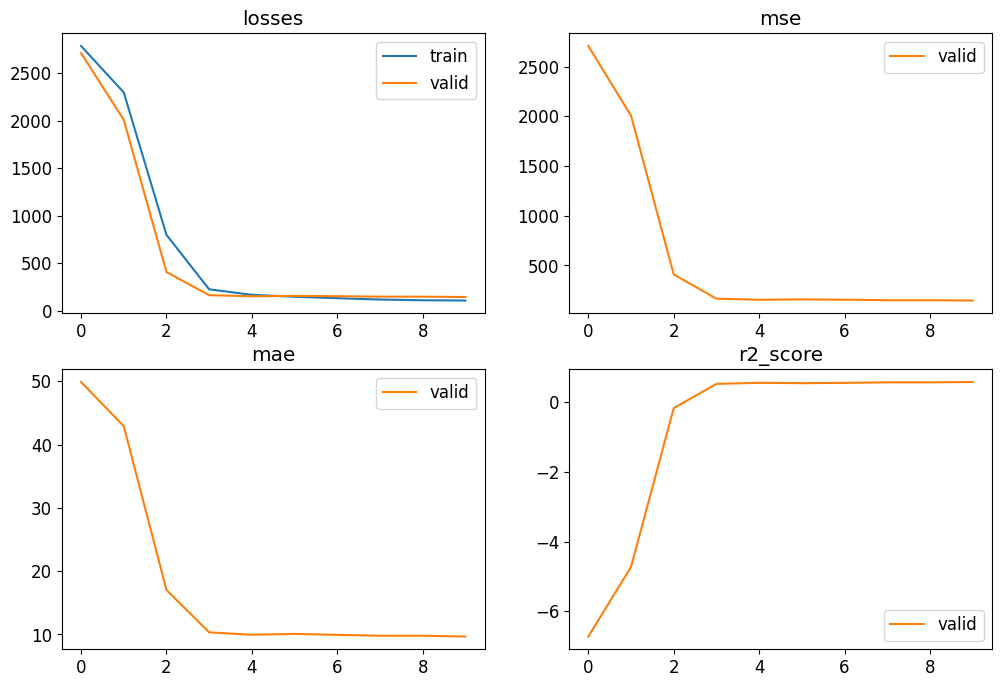

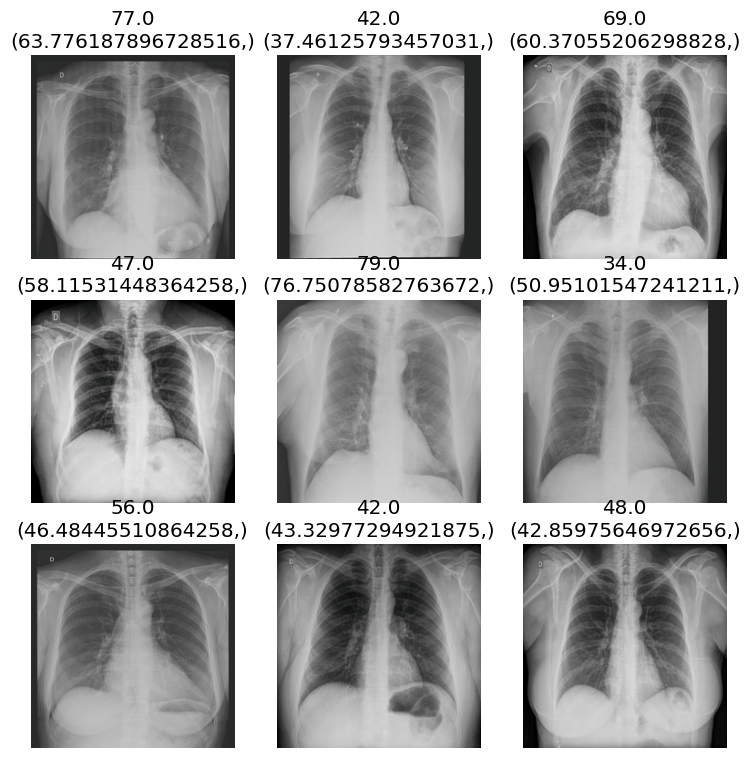

In [ ]:
# Entrenamiento y resultados
learn.fit_one_cycle(n_epoch = 10)
learn.recorder.plot_metrics()
learn.show_results()

Efectivamente, aunque la evolución es parecida a la del apartado anterior, parece que se obtienen resultados mejores. Aún así, queda claro que seguimos teniendo un problema de underfitting y el modelo sigue con las manos atadas. No conviene usar ResNet50 sólo como extractor de características. Veamos cómo es su evaluación.

In [ ]:
# Predicciones del modelo en el conjunto de entrenamiento
train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Calculo MSE, MAE, and R2Score
train_mse = mse(train_preds, train_targs)
train_mae = mae(train_preds, train_targs)
train_r2 = R2Score()(train_preds, train_targs)

# Resultados
print(f"\nMSE on Training Set: {train_mse.item():.4f}")
print(f"MAE on Training Set: {train_mae.item():.4f}")
print(f"R² Score on Training Set: {train_r2:.4f}")


MSE on Training Set: 44.3287
MAE on Training Set: 5.2714
R² Score on Training Set: 0.8706


In [ ]:
# Predicciones del modelo en el conjunto de validación
valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)

# Calculo MSE, MAE, and R2Score
valid_mse = mse(valid_preds, valid_targs)
valid_mae = mae(valid_preds, valid_targs)
valid_r2 = R2Score()(valid_preds, valid_targs)

# Resultados
print(f"\nMSE on Validation Set: {valid_mse.item():.4f}")
print(f"MAE on Validation Set: {valid_mae.item():.4f}")
print(f"R² Score on Validation Set: {valid_r2:.4f}")


MSE on Validation Set: 147.1360
MAE on Validation Set: 9.6699
R² Score on Validation Set: 0.5805


In [ ]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(test_files, with_labels = True)

# Predicciones del modelo entrenado en el conjunto de test
test_preds, test_targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Calculo MSE, MAE, and R2Score
test_mse = mse(test_preds, test_targs)
test_mae = mae(test_preds, test_targs)
test_r2 = R2Score()(test_preds, test_targs)

# Resultado
print(f"\nMSE on Test Set: {test_mse.item():.4f}")
print(f"MAE on Test Set: {test_mae.item():.4f}")
print(f"R² Score on Test Set: {test_r2:.4f}")


MSE on Test Set: 153.4533
MAE on Test Set: 9.9611
R² Score on Test Set: 0.6020


El MSE y el MAE siguen siendo algo elevados, aunque mucho mejor que antes. Pero el R2score nos indica una mejora considerable, en comparación con el apartado anterior. Aunque estamos lejos del $1$, ya no es el resultado desastroso de antes. Parece que la cabecera de fastai nos ayuda mucho, aunque tampoco puede hacer lo imposible. La situación ha mejorado pero el resultado no es muy satisfactorio.

## <font color='blue'>3.4. Hacemos un ajuste fino (fine-tuning) de toda la red partiendo de los pesos de ImageNet.

Por último queremos hacer fine tuning. Para eso seguimos usando `vision_learner` con el que haremos `learn.fine_tune`. Este método se encarga el sólo de congelar-descongelar las capas correspondientes. En una primera etapa `fine_tune` congela el modelo y entrena solo la cabecera, y después descongela todo el modelo y lo entrena, con un learning rate distinto para las distintas capas (las más profundas tienen un rate más pequeño). De esta forma se mantiene el conocimiento de bajo nivel adquirido por el modelo preentrenado y se adapta el conocimiento de nivel más alto a las necesidades de nuestro problema específico.

In [ ]:
# Learner
learn = vision_learner(dls, models.resnet50, metrics=[mse, mae, R2Score()])
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

Como podemos ver, por defecto las capas de batch normalization y la cabecera son entrenables y las demás no, pero todo esto no importa ya que vamos a hacer fine-tuning, que se encargará de congelar-descongelar las capas correspondientes en el proceso. Procedemos a entrenar.

epoch,train_loss,valid_loss,mse,mae,r2_score,time
0,2224.623047,1578.469238,1578.469238,37.533901,-3.499891,04:06


epoch,train_loss,valid_loss,mse,mae,r2_score,time
0,899.726807,481.511902,481.511902,19.380919,-0.372692,01:16
1,190.632599,126.015404,126.015404,9.051288,0.640756,01:14
2,100.741814,106.257950,106.257950,8.241629,0.697080,01:13


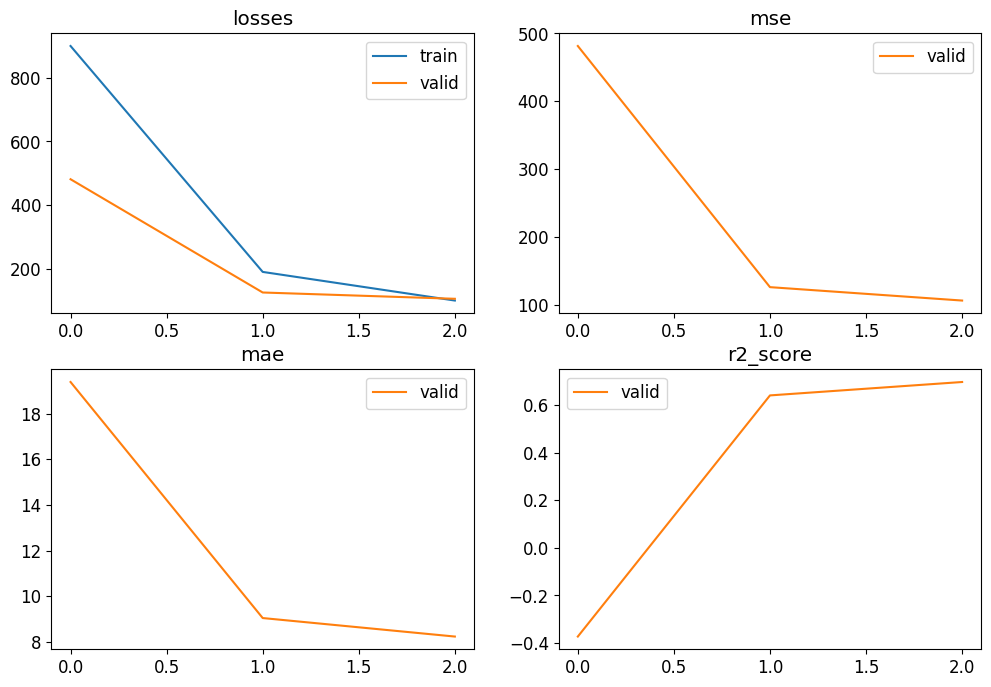

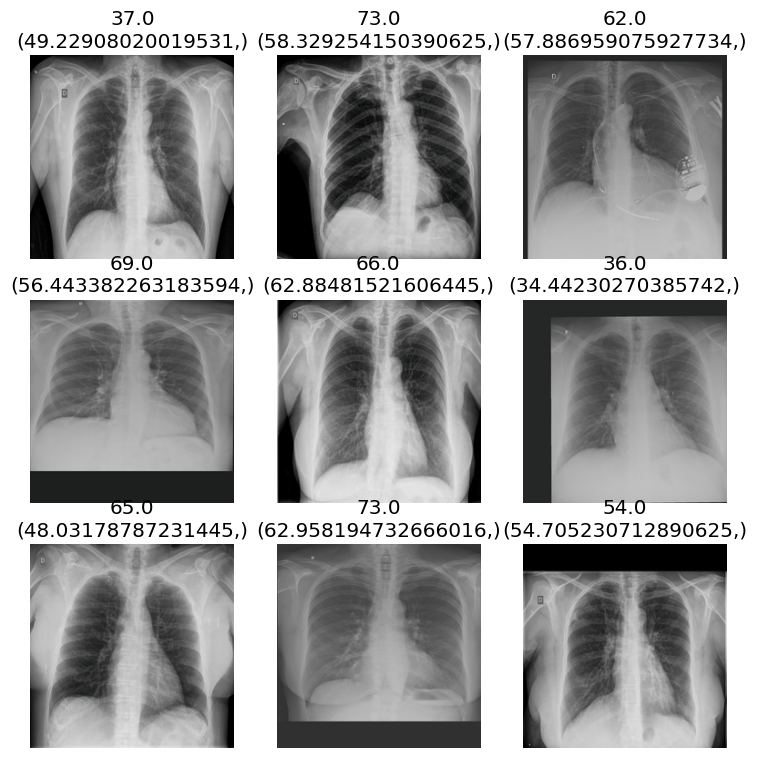

In [ ]:
# Entrenamiento y resultados
learn.fine_tune(epochs = 3)
learn.recorder.plot_metrics()
learn.show_results()

Como podemos ver, en la primera época cuando entrenamos solo la cabecera la pérdida es muy grande, igual que cuando entrenamos con ResNet50 como extractor de características, pero después cae drásticamente cuando empezamos a entrenar el modelo entero, partiendo de pesos preentrenados y entrenando capas profundas y menos profundas con learning rate más pequeños/más grandes. Aunque la pérdida en validation ya no mejora mucho, aun así se podría entrenar una o dos épocas más evitando overfitting. En general el resultado obtenido es relativamente satisfactorio, veamos los conjuntos de entrenamiento, validación y test.

In [ ]:
# Predicciones del modelo en el conjunto de entrenamiento
train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Calculo MSE, MAE, and R2Score
train_mse = mse(train_preds, train_targs)
train_mae = mae(train_preds, train_targs)
train_r2 = R2Score()(train_preds, train_targs)

# Resultados
print(f"\nMSE on Training Set: {train_mse.item():.4f}")
print(f"MAE on Training Set: {train_mae.item():.4f}")
print(f"R² Score on Training Set: {train_r2:.4f}")


MSE on Training Set: 42.4374
MAE on Training Set: 5.1181
R² Score on Training Set: 0.8762


In [ ]:
# Predicciones del modelo en el conjunto de validación
valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)

# Calculo MSE, MAE, and R2Score
valid_mse = mse(valid_preds, valid_targs)
valid_mae = mae(valid_preds, valid_targs)
valid_r2 = R2Score()(valid_preds, valid_targs)

# Resultados
print(f"\nMSE on Validation Set: {valid_mse.item():.4f}")
print(f"MAE on Validation Set: {valid_mae.item():.4f}")
print(f"R² Score on Validation Set: {valid_r2:.4f}")


MSE on Validation Set: 106.2579
MAE on Validation Set: 8.2416
R² Score on Validation Set: 0.6971


In [ ]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(test_files, with_labels = True)

# Predicciones del modelo entrenado en el conjunto de test
test_preds, test_targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Calculo MSE, MAE, and R2Score
test_mse = mse(test_preds, test_targs)
test_mae = mae(test_preds, test_targs)
test_r2 = R2Score()(test_preds, test_targs)

# Resultado
print(f"\nMSE on Test Set: {test_mse.item():.4f}")
print(f"MAE on Test Set: {test_mae.item():.4f}")
print(f"R² Score on Test Set: {test_r2:.4f}")


MSE on Test Set: 96.9922
MAE on Test Set: 7.8865
R² Score on Test Set: 0.7484


El resultado obtenido es mejor que en los dos apartados anteriores, aunque algo peor que entrenar de scratch. Discutiremos en detalle las ventajas y desventajas de usar fine-tuning en las conclusiones. Aquí simplemente diremos que el MAE es razonable y el R2score algo mejor, aunque sigue estando lejos del $1$ que queremos. Teniendo en cuenta que este es el resultado obtenido con un uso mínimo de recursos (muy pocas épocas de entrenamiento), se podría decir que no está nada mal.

## <font color='blue'>Conclusiones. ¿Qué conclusiones se pueden extraer en base a toda la experimentación anterior? En caso de que nos enfrentemos a un nuevo problema, ¿qué opción, u opciones, de entre las anteriores, parece a priori la más razonable? ¿Por qué?

Viendo los resultados que hemos obtenido, parece que nos ha ido mejor con entrenamiento from scratch y después con fine-tuning. Esto tiene sentido ya que como hemos dicho antes, el dominio del problema es bastante específico y congelar todas las capas del modelo preentrenado no es muy apropiado. De hecho hago un resumen de las 3 técnicas en una tabla abajo. Usar un modelo preentrenado sólo como extractor de características tiene más sentido cuando el dataset es muy pequeño, en cuyo caso no tenemos muchas opciones, o si el dominio es muy similar, en cuyo caso ajustar la cabecera nueva a la tarea que tenemos es lo más apropiado, reutilizando el conocimiento adquirido por el modelo en otro dataset mucho más grande lo máximo posible.

Si tenemos un dominio muy diferente y tenemos suficientes recursos, tiempo y datos, es buena idea entrenar from scratch y aprovechar la arquitectura complicada del modelo para un problema específico que tenemos. Esto se puede interpretar como cuando quieres tener a un especialista en un ámbito concreto, es más fácil entrenar a alguien desde cero que reentrenar a un especialista en otro dominio. Aquí pasa lo mismo, el único problema es que necesitamos muchos recursos para ello (tiempo, dinero, esfuerzo, etc.). En nuestro caso parece que el dataset es suficiente para obtener resultados buenos, pero en general es aconsejable tener más datos.

Y por último, con fine-tuning conseguimos encontrar un balance entre flexibilidad y aprovechamiento de conocimientos adquiridos previamente. En una primera etapa congelamos el modelo salvo la cabecera y la ajustamos, después descongelamos y entrenamos todo el modelo, partiendo de pesos preentrenados y entrenando capas más profundas con un learning rate más pequeño que en las capas menos profundas. De esta forma conseguimos reutilizar conocimientos adquiridos de nivel bajo, como son los bordes, que no dependen tanto del dominio del problema y no deberían cambiar mucho, y simultáneamente permitimos reentrenar capas menos profundas que sí trabajan con características más específicas del dominio. En nuestro caso como es esperable, este método funciona bastante bien.

Si nos enfrentamos a un problema nuevo, antes de decidir hay que pensar en qué situación estamos, viendo la tabla que se ofrece debajo. Dependiendo del tamaño del dataset, el dominio, y otros factores, podemos optar por alguna, o algunas, de las opciones que tenemos. En general, una forma de atacar el problema sería buscar un modelo preentrenado con imágenes de un dominio parecido al nuestro e intentar hacer fine-tuning o usarlo como extractor de características si queremos evitar sobreajuste. Pero si disponemos de muchos recursos, podríamos considerar entrenar desde 0.

| **Método**                      | **Ventajas**                                          | **Desventajas**                                      | **Útil cuando...**                                 |
|----------------------------------|------------------------------------------------------|-----------------------------------------------------|---------------------------------------------------|
| **Extractor de características** | Rápido, eficiente y simple.                          | No adapta el modelo al nuevo dominio.              | Dataset pequeño o dominio similar al preentrenado. |
| **Fine-tuning**                  | Balance entre flexibilidad y aprovechamiento previo. | Más costoso y riesgo de sobreajuste.               | Dataset moderado y dominio algo diferente.        |
| **Entrenar desde cero**          | Máxima personalización.                              | Requiere dataset grande y recursos intensivos.     | Dataset grande y dominio muy diferente.           |
